# Setup

Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from keras import models, layers
import matplotlib.pyplot as plt
import os
import cv2
from google.colab.patches import cv2_imshow as show
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import gc

# Making a dataset

Because the data is temporal in nature, the label for an input will be the next input in sequence.

## Loading Images

In [ ]:
pngs_dir = "/content/drive/MyDrive/ENEE439D Group Project/Cloud Data /PNGs"

In [ ]:
images = []
for filename in os.listdir(pngs_dir):
  if (filename.find("Masked") >= 0):
    images.append(filename)

In [ ]:
images.sort()
data = []
for name in images:
  datapoint = cv2.imread(pngs_dir + "/" + name,0)
  data.append(datapoint)

In [ ]:
data = np.array(data)
print(data.shape)

(2001, 292, 583)


In [ ]:
gc.collect()

0

## Normalize the Data

In [ ]:
def resize_image(image):
  padding_column = np.zeros((image.shape[0],1),dtype=image.dtype)
  resized_image = np.concatenate((image,padding_column), axis=1)
  return resized_image

In [ ]:
data = np.array([resize_image(img) for img in data])

In [ ]:
data_norm = data - data.mean()
del data
gc.collect()

0

In [ ]:
print(data_norm.shape)

(2001, 292, 584)


## Data vs Labels

In [ ]:
labels = data_norm[4:]
data_in = data_norm[0:-4]
del data_norm

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_in, labels, test_size=0.33)

In [ ]:
gc.collect()

0

# Convolutional Model w/o Optical Flow

In [ ]:
# Input layer
input_img = layers.Input(shape=(292,584,1))

# Hidden layers
x = layers.Conv2D(32, (3,3), activation='relu',padding='same')(input_img)
x = layers.Dropout(0.25)(x)
x = layers.Conv2D(64, (3,3), activation='relu',padding='same')(x)
x = layers.Dropout(0.25)(x)
# x = layers.Conv2D(32, (3,3), activation='relu',padding='same')(x)
convolved = layers.Conv2D(1, (3,3), activation='relu',padding='same')(x)

conv = models.Model(input_img, convolved)
conv.compile(optimizer='adam',loss='mse')
conv.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 292, 584, 1)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 292, 584, 32)      320       
                                                                 
 dropout_2 (Dropout)         (None, 292, 584, 32)      0         
                                                                 
 conv2d_4 (Conv2D)           (None, 292, 584, 64)      18496     
                                                                 
 dropout_3 (Dropout)         (None, 292, 584, 64)      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 292, 584, 1)       577       
                                                                 
Total params: 19393 (75.75 KB)
Trainable params: 19393 (75.

In [ ]:
gc.collect()

252

## Create Checkpoints & Train

In [ ]:
checkpoint_path = '/content/drive/MyDrive/ENEE439D Group Project/Cloud Predictions/Convolutional Model With Separation/model'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
history = conv.fit(
    X_train,
    y_train,
    batch_size=25,
    epochs=10,
    validation_data=(X_test, y_test),
    validation_batch_size = 25,
    callbacks=[cp_callback])

Epoch 1/10
54/54 [==============================] - ETA: 0s - loss: 1296.5497
Epoch 1: saving model to /content/drive/MyDrive/ENEE439D Group Project/Cloud Predictions/Convolutional Model With Separation/model
54/54 [==============================] - 25s 449ms/step - loss: 1296.5497 - val_loss: 1236.1670
Epoch 2/10
54/54 [==============================] - ETA: 0s - loss: 1242.3199
Epoch 2: saving model to /content/drive/MyDrive/ENEE439D Group Project/Cloud Predictions/Convolutional Model With Separation/model
54/54 [==============================] - 22s 402ms/step - loss: 1242.3199 - val_loss: 1224.8130
Epoch 3/10
54/54 [==============================] - ETA: 0s - loss: 1234.0453
Epoch 3: saving model to /content/drive/MyDrive/ENEE439D Group Project/Cloud Predictions/Convolutional Model With Separation/model
54/54 [==============================] - 22s 404ms/step - loss: 1234.0453 - val_loss: 1222.0027
Epoch 4/10
54/54 [==============================] - ETA: 0s - loss: 1230.0676
Epoch 4

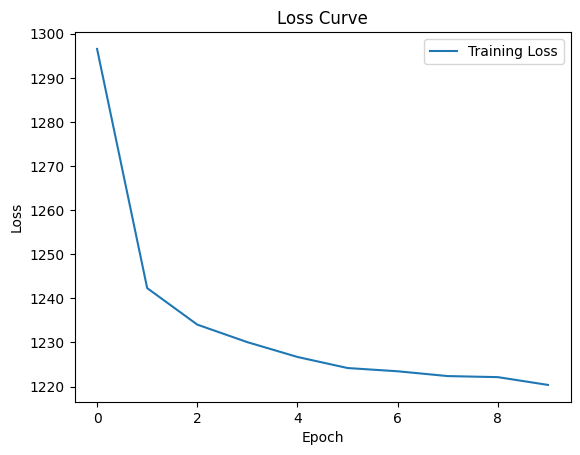

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Loss Curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
gc.collect()

4662

## Load Model

In [ ]:
# Loads the weights
# conv.load_weights(checkpoint_path)

## Model Training Analysis

### Loss Curves and Metrics

### Visualize Output

21/21 [==============================] - 2s 82ms/step


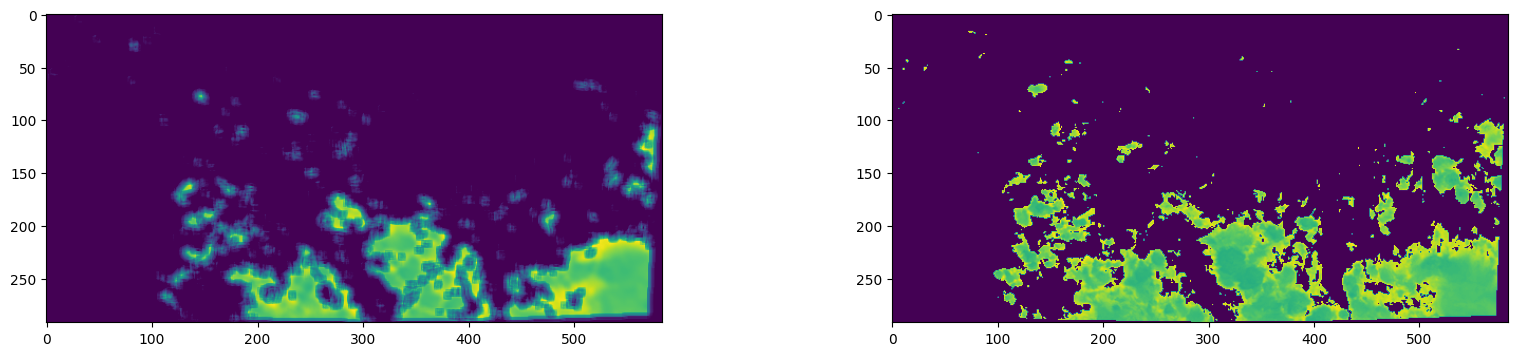

In [ ]:
decoded_images = conv.predict(X_test)

plt.figure(figsize=(20,4))
ax = plt.subplot(1,2,1)
plt.imshow(decoded_images[11])
ax = plt.subplot(1,2,2)
plt.imshow(y_test[11])
plt.show()

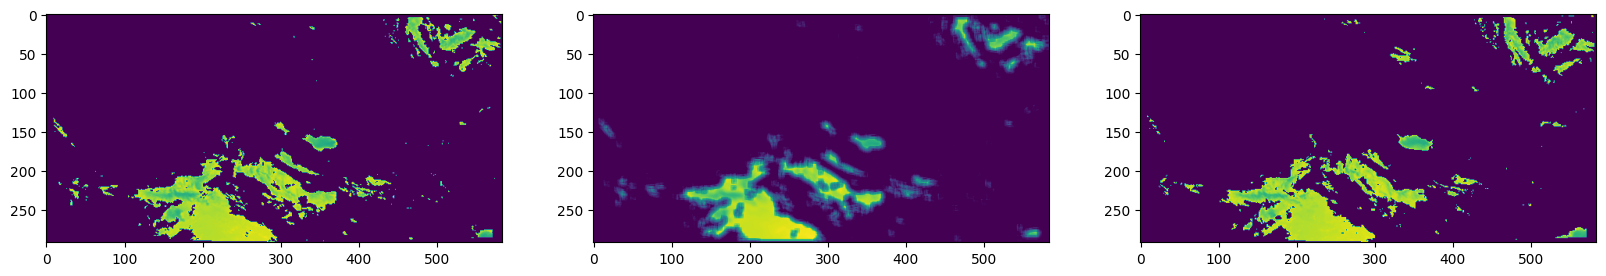

In [ ]:
img_index = np.random.randint(0,len(y_test))
plt.figure(figsize=(20,10))
ax = plt.subplot(1,3,1)
plt.imshow(X_test[img_index])
ax = plt.subplot(1,3,2)
plt.imshow(decoded_images[img_index])
ax = plt.subplot(1,3,3)
plt.imshow(y_test[img_index])
plt.show()

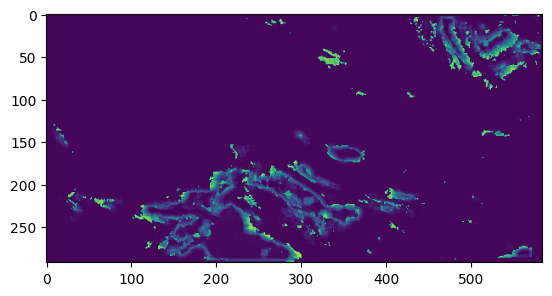

In [ ]:
difference = ((decoded_images[img_index][:][:]) - (y_test[img_index].reshape(292,584,1)))**2
plt.imshow(difference)
plt.show()

In [ ]:
gc.collect()

9845

# Predicting Futher Into the Future

In [ ]:
starting_img = data_in[0]
ending_img = data_in[11]
truth = data_in[0:11]
num_preds = 10

In [ ]:
gc.collect()

0

In [ ]:
prev = starting_img
preds = [starting_img]
for i in range(num_preds):
  prev = conv.predict(np.array([starting_img,]))
  preds.append(prev.reshape(292,584))

1/1 [==============================] - 0s 17ms/step


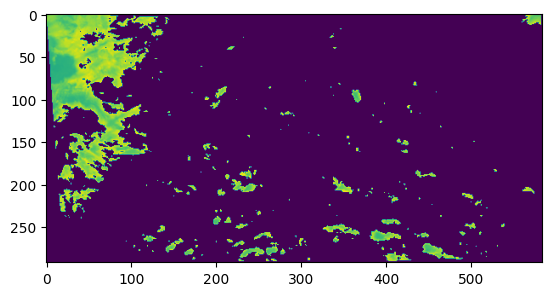

In [ ]:
plt.imshow(starting_img)
plt.show()

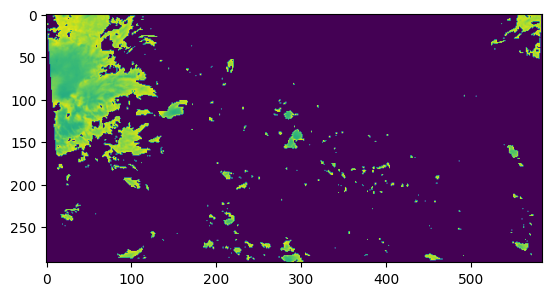

In [ ]:
plt.imshow(ending_img)
plt.show()

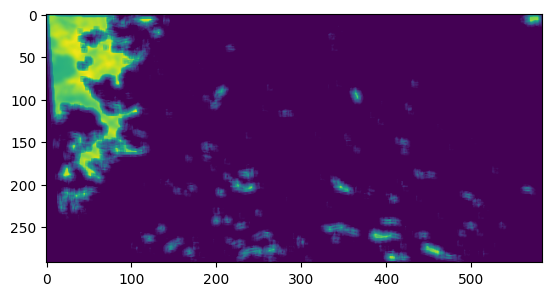

In [ ]:
plt.imshow(prev.reshape(292,584,1))
plt.show()

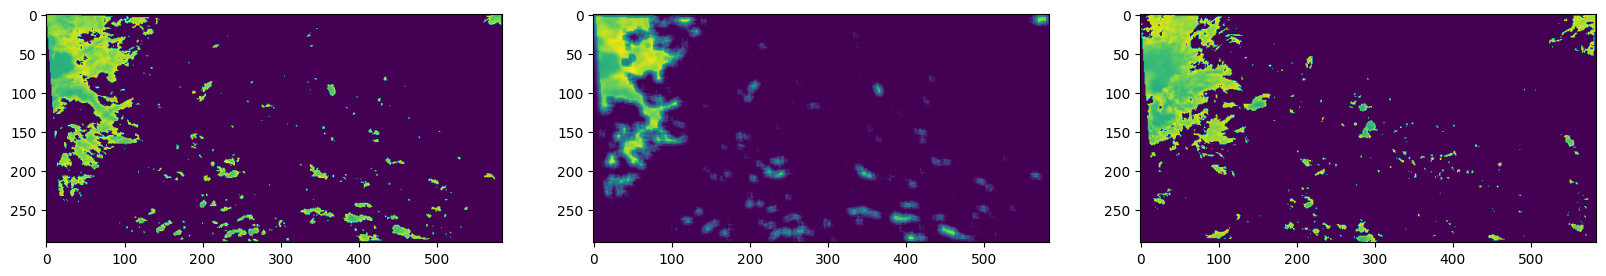

In [ ]:
plt.figure(figsize=(20,10))
ax = plt.subplot(1,3,1)
plt.imshow(starting_img)
ax = plt.subplot(1,3,2)
plt.imshow(prev.reshape(292,584))
ax = plt.subplot(1,3,3)
plt.imshow(ending_img)
plt.show()

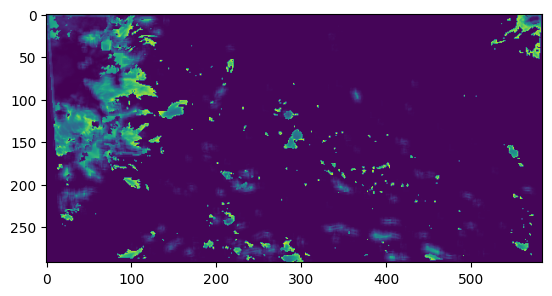

In [ ]:
difference = ((prev.reshape(292,584,1)) - (ending_img.reshape(292,584,1)))**2
plt.imshow(difference)
plt.show()

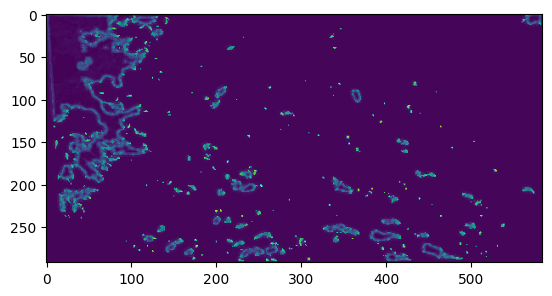

In [ ]:
difference = ((prev.reshape(292,584,1)) - (starting_img.reshape(292,584,1)))**2
plt.imshow(difference)
plt.show()

# Animation

In [ ]:
import imageio
imageio.mimsave('/content/drive/MyDrive/ENEE439D Group Project/Cloud Predictions/Convolutional Model/predictions.gif', preds)
imageio.mimsave('/content/drive/MyDrive/ENEE439D Group Project/Cloud Predictions/Convolutional Model/true.gif', truth)